# Agent Supervisor

![](https://d.pr/i/gKezSO+)

In [2]:
%pip install -Uq langchain langchain-openai langchain-community langchain-tavily langchain-experimental langgraph

Note: you may need to restart the kernel to use updated packages.


In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")
os.environ['TAVILY_API_KEY'] = os.getenv("tavily_key")

## 도구 생성

In [4]:
from langchain_tavily import TavilySearch    # Tavily 웹검색 Tool
from langchain_experimental.tools import PythonREPLTool  # 파이썬 코드 실행 Tool

tavily_tool = TavilySearch(max_results=3)
python_repl_tool = PythonREPLTool() # 보안위험 있음.


In [5]:
# 헬퍼함수
# - 에이젼트 노드 실행기: 각 에이젼트의 답변을 사람메세지로 재가공.
from langchain_core.messages import HumanMessage

# 에이전트 실행 후, 마지막 응답을 HumanMessage로 감싸 반환하는 함수
def agent_node(state, agent, name):
    response = agent.invoke(state)  # 에이전트 실행
    # 에이전트의 응답 결과를 지정한 name의 HumanMessage로 변환
    return {'messages': [HumanMessage(content=response['messages'][-1].content, name=name)]}

## Supervisor Agent

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder  # 멀티메시지 프롬프트 구성 요소
from langchain.chat_models import init_chat_model
from enum import Enum
from pydantic import BaseModel  # 구조화 출력용
from typing import Literal      # 라우팅 결과 제한용

members = ['Researcher', 'Coder'] # 하위 에이젼트
system_prompt = """
다음 작업자들 간의 대화를 관리하는 관리자로서 당신은 다음 작업을 수행해야 합니다: {members}.

아래의 사용자 요청을 참고하여, 다음 작업을 수행할 작업자를 지정하세요.
각 작업자는 작업을 수행하고 그 결과와 상태를 보고할 것입니다.
모든 작업이 완료되면 FINISH로 응답하세요."
"""

options = members + ['FINISH']  # Supervisor가 선택할 수 있는 선택지

class RouteResponse(BaseModel):  # Supervisor의 구조화 출력
    next: Literal["FINISH", "Researcher", "Coder"]  # 3가지 중 1개로 제한

prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),
    MessagesPlaceholder(variable_name='messages'),  # 지금까지의 대화(messages)를 그대로 전달할 표시자
    ('system', '''
위 대화를 참고하여, 누가 다음으로 행동해야 하나요? 아니면 작업을 FINISH 해야 하나요?
다음중 하나를 선택하세요: {options}
''')
]).partial(options=options, members=', '.join(members))  # options/member를 partial로 미리 고정

llm = init_chat_model('gpt-4.1')

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    return supervisor_chain.invoke(state)  # state(messages 포함)를 입력받아 next 값 3개중 하나를 출력

c:\Users\Playdata\nlp\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Graph 조립

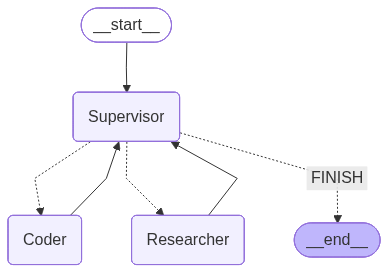

In [7]:
from typing import TypedDict, Annotated, List        # 상태 타입 정의용
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages     # messages 누적 처리 유틸리티
from langchain_core.messages import BaseMessage      # messages 타입 힌트용
from langchain.agents import create_agent  # Tool 사용하는 에이전트 생성
import functools  # partial를 사용

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]  # messages에는 add_messages로 누적시키는 규칙
    next: str  # Supervisor가 결정하는 다음 노드 이름

# functools.partial(): 기존함수의 일부인자를 미리 채운 함수를 반환
research_agent = create_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name='Researcher')  # 웹검색 에이전트 노드

code_agent = create_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name='Coder')  # 파이썬 실행 가능한 에이전트 노드

# 그래프 작성
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("Supervisor", supervisor_agent)

# 시작 -> Suvervisor
# Supervisor -> Researcher/Coder/END
# Researcher -> Supervisor
# Coder -> Supervisor
workflow.add_edge(START, 'Supervisor')
workflow.add_edge('Researcher', 'Supervisor')
workflow.add_edge('Coder', 'Supervisor')

# Supervisor의 next 값에 따른 분기 맵
conditional_map = {
    member: member for member in members  # 'Researcher' / 'Coder'는 동일한 이름의 노드로 라우팅
}
conditional_map['FINISH'] = END  # FINISH면 종료로 라우팅
# STATE['next']를 기준으로 조건 분기 추가
workflow.add_conditional_edges('Supervisor', lambda state: state['next'], conditional_map)
graph = workflow.compile()
graph

In [14]:
# 코드 생성 요청
for chunk in graph.stream({
    'messages': [
        ('human', '파이썬 Helloworld 출력하는 코드 작성하고, 콘솔에 출력해줘.')
        # ('human', '오늘 2026년 1월 22일 기준 삼성전자 주식 최근 추이를 matplotlib 시각화해줘')
    ]
}):
    print(chunk)

{'Supervisor': {'next': 'Coder'}}
{'Coder': {'messages': [HumanMessage(content='아래는 파이썬에서 "Hello, World!"를 출력하는 코드입니다:\n\n```python\nprint(\'Hello, World!\')\n```\n\n실행 결과는 콘솔에 다음과 같이 출력됩니다:\n```\nHello, World!\n```\n', additional_kwargs={}, response_metadata={}, name='Coder', id='5c66d644-b6c6-4b88-b248-97e837ee3338')]}}
{'Supervisor': {'next': 'FINISH'}}


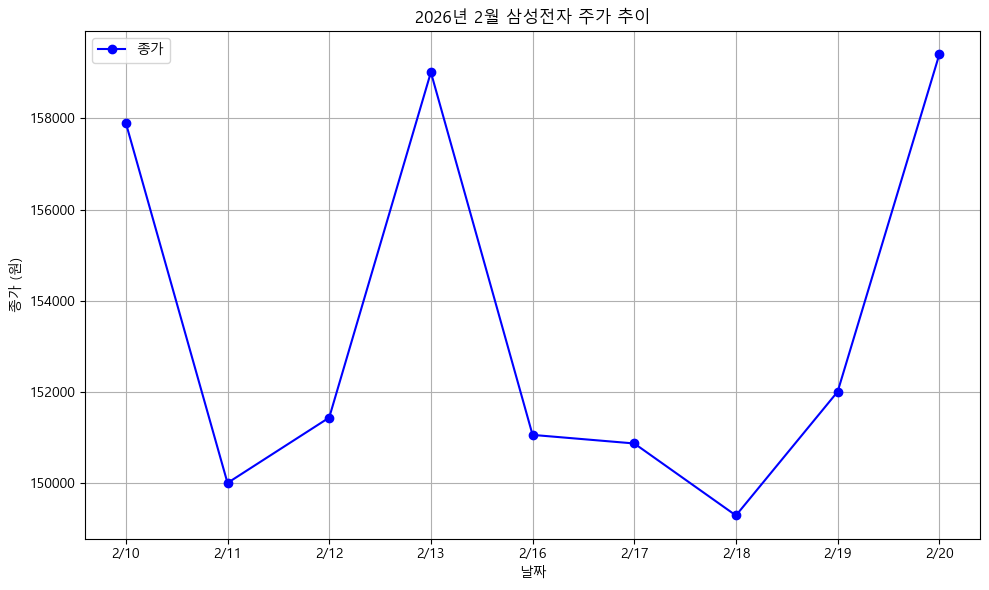

아래는 2026년 2월 삼성전자 주가 추이를 시각화하는 matplotlib 코드입니다. 한글이 깨지지 않도록 'Malgun Gothic' 폰트로 설정되어 있습니다. (macOS라면 'AppleGothic', 리눅스라면 'NanumGothic' 등으로 바꿔주세요.)

```python
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정 (Windows 기준, 필요시 경로 조정)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

dates = ['2/10', '2/11', '2/12', '2/13', '2/16', '2/17', '2/18', '2/19', '2/20']
prices = [157903, 150008, 151441, 159013, 151062, 150874, 149295, 152009, 159405]

plt.figure(figsize=(10, 6))
plt.plot(dates, prices, marker='o', linestyle='-', color='blue', label='종가')
plt.title('2026년 2월 삼성전자 주가 추이')
plt.xlabel('날짜')
plt.ylabel('종가 (원)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
```

위 코드를 복사해 실행하면 삼성전자 주가 변화 그래프가 한글이 제대로 표시된 채로 나타납니다. 
혹시 다른 운영체제거나 폰트 경로가 다르면 font_path만 수정하세요!

In [13]:
from IPython.display import Markdown

response = graph.invoke({
    'messages': [
        ('human', '오늘 2026년 2월 12일 기준 삼성전자 주식 최근 추이를 한글이 깨지지 않게 matplotlib 시각화해줘.')
    ]
})
Markdown(response['messages'][-1].content)

In [15]:
# 자료조사 요청
for chunk in graph.stream({
    'messages': [
        ('human', '저속노화에 대한 레포트 작성해줘')
    ]
}):
    print(chunk)

{'Supervisor': {'next': 'Researcher'}}
{'Researcher': {'messages': [HumanMessage(content='물론입니다! 아래는 저속노화(늦은 노화, Slow Aging)에 대한 레포트 예시입니다.\n\n---\n\n# 저속노화(Slow Aging)에 대한 레포트\n\n## 1. 서론\n\n현대사회에서는 평균 수명이 빠르게 증가하고 있지만, 건강하게 오래 사는 것, 즉 ‘건강수명’이 중요한 화두로 떠오르고 있습니다. 이에 따라 신체적·정신적 기능 저하를 최대한 늦추고, 만성질환이나 노인성 질환을 예방하여 노화를 ‘서서히’ 진행시키는 저속노화(slow aging)에 대한 관심이 높아지고 있습니다. 본 레포트에서는 저속노화의 개념, 원리, 실천 방법, 그리고 최신 연구 동향에 대해 살펴보고자 합니다.\n\n## 2. 저속노화의 개념\n\n저속노화란 생물학적, 환경적, 생활습관적 요인을 관리하여 노화의 진행 속도를 늦추는 것을 의미합니다. 이는 노화를 완전히 멈추는 것이 아니라, 각종 질병 발병 및 신체기능 저하의 위험을 최소화하고, 보다 오랜 기간 동안 청년기와 같은 건강한 상태를 유지하려는 시도입니다.\n\n## 3. 저속노화의 주요 원리\n\n1. **세포 및 유전체 보호**  \n   세포 노화의 근본적인 원인은 유전자 손상, 텔로미어 단축, 산화적 스트레스 등입니다. 항산화제 섭취, 규칙적인 운동 등은 세포와 유전체 손상을 줄여줍니다.\n\n2. **호르몬 균형 유지**  \n   성장호르몬, 성호르몬 등은 노화에 큰 영향을 미칩니다. 적절한 신체활동, 영양관리는 호르몬 균형에 도움을 줍니다.\n\n3. **만성 염증 억제**  \n   노화와 관련된 만성 저등급 염증(inflammaging)이 각종 질환의 원인이 됩니다. 항염증 식품, 금연, 스트레스 관리가 중요합니다.\n\n## 4. 저속노화를 위한 실천 방법\n\n1. **균형 잡힌 영양 섭취**  \n   - 신선한 채소와 과일, 통곡물, 양질의 